In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

music = pd.DataFrame()
music['duration'] = [184, 134, 243, 186, 122, 197, 294, 382, 102, 264, 
                     205, 110, 307, 110, 397, 153, 190, 192, 210, 403,
                     164, 198, 204, 253, 234, 190, 182, 401, 376, 102]
music['loudness'] = [18, 34, 43, 36, 22, 9, 29, 22, 10, 24, 
                     20, 10, 17, 51, 7, 13, 19, 12, 21, 22,
                     16, 18, 4, 23, 34, 19, 14, 11, 37, 42]
music['bpm'] = [ 105, 90, 78, 75, 120, 110, 80, 100, 105, 60,
                  70, 105, 95, 70, 90, 105, 70, 75, 102, 100,
                  100, 95, 90, 80, 90, 80, 100, 105, 70, 65]
neighbor = 10

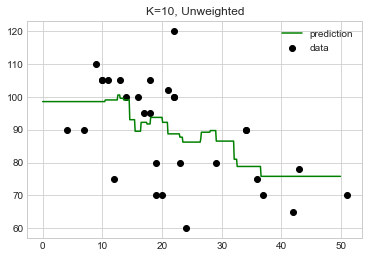

In [2]:
from sklearn import neighbors
sns.set_style('whitegrid')

# Build our model.
knn = neighbors.KNeighborsRegressor(n_neighbors=neighbor)
X = pd.DataFrame(music.loudness) #putting in dataframe causes X to work inproperly
Y = music.bpm
knn.fit(X, Y)

# Set up our prediction line. Prediction line has to be array of arrays; 1 column of data only
T = np.arange(0, 50, 0.1)[:, np.newaxis]

# Trailing underscores are a common convention for a prediction.
Y_ = knn.predict(T)

plt.scatter(X.loudness, Y, c='k', label='data')
plt.plot(T, Y_, c='g', label='prediction')
plt.legend()
plt.title('K=10, Unweighted')
plt.show()

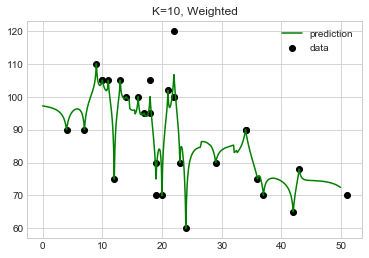

In [3]:
# Run the same model, this time with weights.
knn_w = neighbors.KNeighborsRegressor(n_neighbors=neighbor, weights='distance')
X = pd.DataFrame(music.loudness)
Y = music.bpm
knn_w.fit(X, Y)

# Set up our prediction line.
T = np.arange(0, 50, 0.1)[:, np.newaxis]

Y_ = knn_w.predict(T)

plt.scatter(X.loudness, Y, c='k', label='data')
plt.plot(T, Y_, c='g', label='prediction')
plt.legend()
plt.title('K=10, Weighted')
plt.show()

In [4]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(knn, X, Y, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
score_w = cross_val_score(knn_w, X, Y, cv=5)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))

Unweighted Accuracy: -0.18 (+/- 0.66)
Weighted Accuracy: 0.11 (+/- 0.94)


In [5]:
#tinkering with data to see if we can increase accuracy and/or improve the std between the two
music.head()

,duration,loudness,bpm
0,184,18,105
1,134,34,90
2,243,43,78
3,186,36,75
4,122,22,120


In [6]:
#normalize distance
df = pd.DataFrame()

df['normal_bpm'] = (music.bpm -music.bpm.min()) / (music.bpm.max() - music.bpm.min())
df['normal_duration'] = (music.duration - music.duration.min()) / (music.duration.max() - music.duration.min())
df['normal_loudness'] = (music.loudness - music.loudness.min()) / (music.loudness.max() - music.loudness.min())

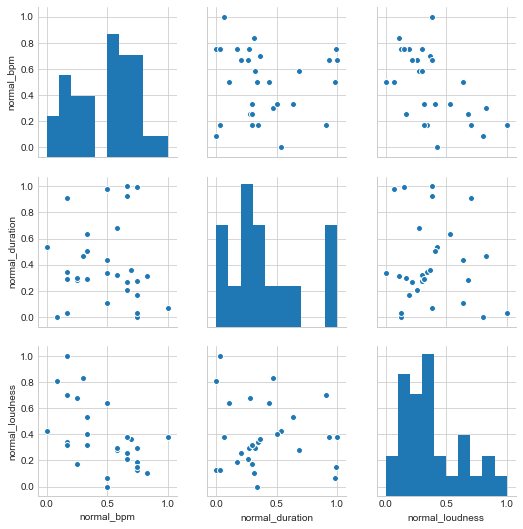

In [7]:
sns.pairplot(df)

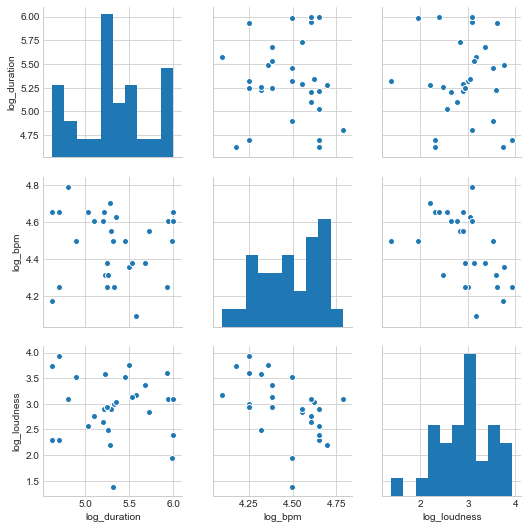

In [8]:
def getLog(x):
    if x > 0:
        return np.log(x)
    return 0

df['log_duration'] = music.duration.apply(getLog)
df['log_bpm'] = music.bpm.apply(getLog)
df['log_loudness'] = music.loudness.apply(getLog)
sns.pairplot(df[['log_duration', 'log_bpm', 'log_loudness']])

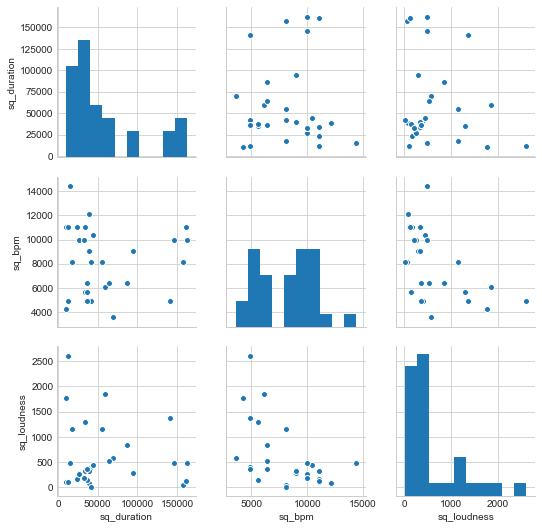

In [9]:
df['sq_duration'] = music.duration ** 2
df['sq_loudness'] = music.loudness ** 2
df['sq_bpm'] = music.bpm ** 2
sns.pairplot(df[['sq_duration', 'sq_bpm', 'sq_loudness']])

In [10]:
df.head()

,normal_bpm,normal_duration,normal_loudness,log_duration,log_bpm,log_loudness,sq_duration,sq_loudness,sq_bpm
0,0.75,0.272425,0.297872,5.214936,4.653960,2.890372,33856,324,11025
1,0.50,0.106312,0.638298,4.897840,4.499810,3.526361,17956,1156,8100
2,0.30,0.468439,0.829787,5.493061,4.356709,3.761200,59049,1849,6084
3,0.25,0.279070,0.680851,5.225747,4.317488,3.583519,34596,1296,5625
4,1.00,0.066445,0.382979,4.804021,4.787492,3.091042,14884,484,14400


In [11]:
#test using duration and bpm
knn = neighbors.KNeighborsRegressor(n_neighbors=neighbor)
X = pd.DataFrame(df.log_duration)
Y = df.log_bpm
knn.fit(X, Y)

knn_w = neighbors.KNeighborsRegressor(n_neighbors=neighbor, weights='distance')
X_ = pd.DataFrame(df.log_duration)
Y_ = df.log_bpm
knn_w.fit(X_, Y_)

score = cross_val_score(knn, X, Y, cv=5)
score_w = cross_val_score(knn_w, X_, Y_, cv=5)

print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))

Unweighted Accuracy: -0.55 (+/- 1.15)
Weighted Accuracy: -0.87 (+/- 0.90)


In [12]:
diff_acc = []

for neighbor_count in range(1, 24):
    knn = neighbors.KNeighborsRegressor(n_neighbors=neighbor_count)
    X = pd.DataFrame(df.log_duration)
    Y = df.log_bpm
    knn.fit(X, Y)
    score = cross_val_score(knn, X, Y, cv=5)
    
    knn_w = neighbors.KNeighborsRegressor(n_neighbors=neighbor_count, weights='distance')
    knn_w.fit(X, Y)
    score_w = cross_val_score(knn_w, X, Y, cv=5)
    
    diff_acc.append([(neighbor_count), (score.mean() - score_w.mean()), (score.std() - score_w.std())])
list(diff_acc)

[[1, 0.0, 0.0],
 [2, 0.2654197256986781, -0.22600206401586448],
 [3, 0.5548725907710343, -0.40978931530839446],
 [4, 0.1665406526215979, -0.051757385531008504],
 [5, 0.25409583765429966, 0.0500304359578817],
 [6, 0.19411620258861473, 0.16789734981110627],
 [7, 0.20806523053044046, 0.21495684204870602],
 [8, 0.30517856970177293, 0.040563644870781124],
 [9, 0.36881411810603126, -0.0461051108724892],
 [10, 0.32401100792612436, 0.12171411815897515],
 [11, 0.3486789823374524, 0.08515545563945448],
 [12, 0.3504228762679441, 0.08970156510351751],
 [13, 0.32167354156900974, 0.1937403625343238],
 [14, 0.3927726049138195, 0.15074378029229074],
 [15, 0.37489764335574133, 0.16122555862794014],
 [16, 0.46174270200758916, -0.03192740139609296],
 [17, 0.42966721671728086, 0.009019735820527564],
 [18, 0.4036605994526013, 0.006043688686852733],
 [19, 0.4395393385841295, 0.05483930081961541],
 [20, 0.4626307541979205, -0.01713418478219647],
 [21, 0.4508490593922673, 0.04918142102321732],
 [22, 0.4595510

In [13]:
#17 neighbors has smallest difference in std
neighbor = 17
knn = neighbors.KNeighborsRegressor(n_neighbors=neighbor)
X = pd.DataFrame(df.log_duration)
Y = df.log_bpm
knn.fit(X, Y)

knn_w = neighbors.KNeighborsRegressor(n_neighbors=neighbor, weights='distance')
X_ = pd.DataFrame(df.log_duration)
Y_ = df.log_bpm
knn_w.fit(X_, Y_)

score = cross_val_score(knn, X, Y, cv=5)
score_w = cross_val_score(knn_w, X_, Y_, cv=5)

print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))

Unweighted Accuracy: -0.41 (+/- 0.83)
Weighted Accuracy: -0.84 (+/- 0.81)
